In [1]:
!pip install -q -U toai

     |████████████████████████████████| 296kB 5.2MB/s 
     |████████████████████████████████| 81kB 26.1MB/s 
     |████████████████████████████████| 153kB 48.6MB/s 
     |████████████████████████████████| 61kB 23.1MB/s 


In [0]:
#!pip install -q -U --pre efficientnet

In [0]:
__import__('toai').__version__

'0.1.28'

In [2]:
!pip install tensorflow==2.0.0-rc0 

  Found existing installation: tensorflow 1.15.0rc3
    Uninstalling tensorflow-1.15.0rc3:
      Successfully uninstalled tensorflow-1.15.0rc3


In [0]:
#!pip install tensorflow-gpu==2.0.0

In [0]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
from toai.imports import *
from toai.data import Dataset, DataParams, DataContainer, split_df
from toai.models import save_keras_model, load_keras_model
from toai.metrics import sparse_top_2_categorical_accuracy
from toai.image import (
    ImageLearner,
    ImageAugmentor,
    ImageDataset,
    ImageParser,
    ImageResizer,
    LearningRateFinder,
    ImageTrainingCycle,
    ImageTrainer,
)
from toai.utils import download_file, unzip, save_file, load_file
import tensorflow as tf
from tensorflow import keras
import cv2
import os
from IPython.display import Image
from google.colab.patches import cv2_imshow
#import efficientnet.keras as efn 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
tf.__version__

'2.0.0-rc0'

In [0]:
DATA_DIR = Path("data/animals")
TEMP_DIR = Path("temp/animals")
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
#!kaggle competitions download --force iwildcam-2019-fgvc6 -p  {str(DATA_DIR)}

In [7]:
 kaggle.api.competition_download_file(
     competition="iwildcam-2019-fgvc6",
     file_name="train_images.zip",
     path=DATA_DIR,
 )

  0%|          | 0.00/26.0G [00:00<?, ?B/s]

100%|██████████| 26.0G/26.0G [03:57<00:00, 118MB/s]

In [8]:
kaggle.api.competition_download_file(
     competition="iwildcam-2019-fgvc6",
     file_name="train.csv",
     path=DATA_DIR,
 )

100%|██████████| 4.95M/4.95M [00:00<00:00, 47.2MB/s]

data exploration

In [0]:
unzip.all_files_in_dir(DATA_DIR, ".zip")

In [0]:
train_df = pd.read_csv(DATA_DIR/'train.csv')

In [11]:
train_df.head().T

,0,1,2,3,4
category_id,19,19,0,0,0
date_captured,2011-05-13 23:43:18,2012-03-17 03:48:44,2014-05-11 11:56:46,2013-10-06 02:00:00,2011-07-12 13:11:16
file_name,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg
frame_num,1,2,1,1,3
id,5998cfa4-23d2-11e8-a6a3-ec086b02610b,588a679f-23d2-11e8-a6a3-ec086b02610b,59279ce3-23d2-11e8-a6a3-ec086b02610b,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,599fbd89-23d2-11e8-a6a3-ec086b02610b
location,33,115,96,57,46
rights_holder,Justin Brown,Justin Brown,Erin Boydston,Erin Boydston,Justin Brown
seq_id,6f084ccc-5567-11e8-bc84-dca9047ef277,6f12067d-5567-11e8-b3c0-dca9047ef277,6faa92d1-5567-11e8-b1ae-dca9047ef277,6f7d4702-5567-11e8-9e03-dca9047ef277,6f1728a1-5567-11e8-9be7-dca9047ef277
seq_num_frames,3,3,1,1,3
width,1024,1024,1024,1024,1024


In [0]:
train_df.category_id.value_counts()

0     131457
19     14106
13      8623
11      7209
8       6938
1       6102
16      5975
17      4759
3       3398
18      3035
4       2210
14      1361
10      1093
22        33
Name: category_id, dtype: int64

In [0]:
IMG_DIMS = (150, 150, 3)

In [0]:
train_df['file_name'] = train_df['file_name'].map(lambda x: os.path.join(DATA_DIR,'{}'.format(x)))

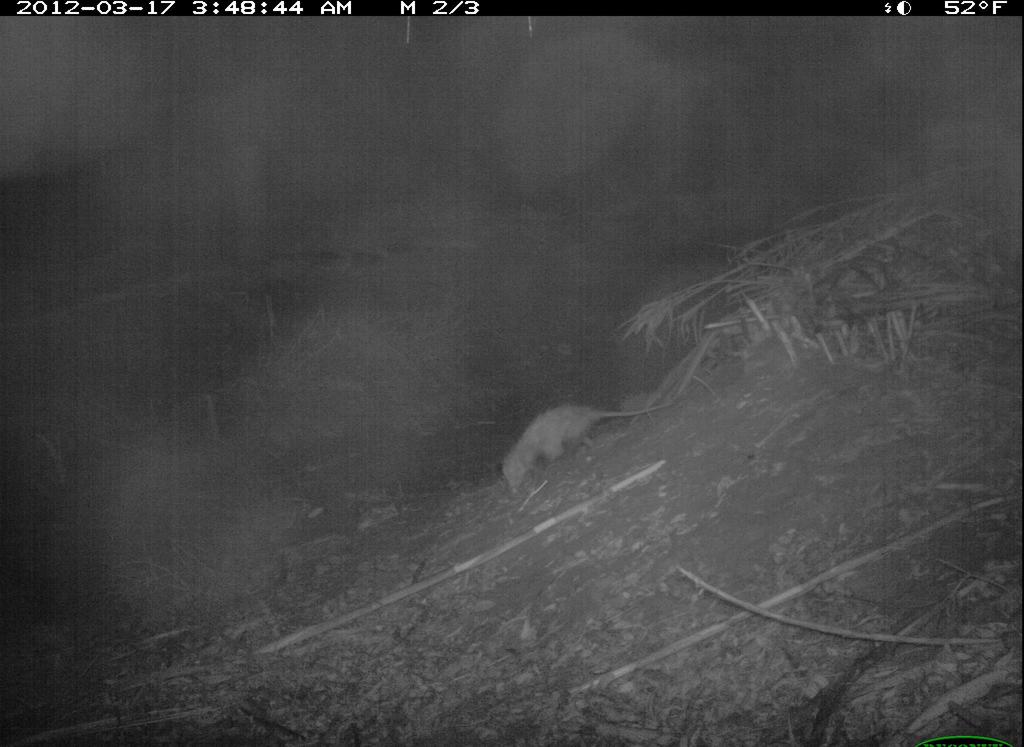

In [14]:
Image(train_df['file_name'][1])

In [13]:
pd.value_counts(train_df['category_id']).plot.bar()

In [0]:
train_df['category_id'].value_counts().plot(kind='bar')
plt.show()

In [15]:
sns.countplot(x='category_id', data=train_df)

In [7]:
train_df.head().T

,0,1,2,3,4
category_id,19,19,0,0,0
date_captured,2011-05-13 23:43:18,2012-03-17 03:48:44,2014-05-11 11:56:46,2013-10-06 02:00:00,2011-07-12 13:11:16
file_name,data/animals/5998cfa4-23d2-11e8-a6a3-ec086b026...,data/animals/588a679f-23d2-11e8-a6a3-ec086b026...,data/animals/59279ce3-23d2-11e8-a6a3-ec086b026...,data/animals/5a2af4ab-23d2-11e8-a6a3-ec086b026...,data/animals/599fbd89-23d2-11e8-a6a3-ec086b026...
frame_num,1,2,1,1,3
id,5998cfa4-23d2-11e8-a6a3-ec086b02610b,588a679f-23d2-11e8-a6a3-ec086b02610b,59279ce3-23d2-11e8-a6a3-ec086b02610b,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,599fbd89-23d2-11e8-a6a3-ec086b02610b
location,33,115,96,57,46
rights_holder,Justin Brown,Justin Brown,Erin Boydston,Erin Boydston,Justin Brown
seq_id,6f084ccc-5567-11e8-bc84-dca9047ef277,6f12067d-5567-11e8-b3c0-dca9047ef277,6faa92d1-5567-11e8-b1ae-dca9047ef277,6f7d4702-5567-11e8-9e03-dca9047ef277,6f1728a1-5567-11e8-9be7-dca9047ef277
seq_num_frames,3,3,1,1,3
width,1024,1024,1024,1024,1024


In [23]:
train_df.describe()

,category_id,frame_num,location,seq_num_frames,width,height
count,196299.000000,196299.000000,196299.00000,196299.000000,196299.0,196299.000000
mean,4.085069,1.404047,65.83003,1.793494,1024.0,747.486600
std,6.749477,0.739637,34.35272,1.026838,0.0,3.128948
min,0.000000,1.000000,0.00000,1.000000,1024.0,747.000000
25%,0.000000,1.000000,30.00000,1.000000,1024.0,747.000000
50%,0.000000,1.000000,70.00000,1.000000,1024.0,747.000000
75%,8.000000,2.000000,96.00000,3.000000,1024.0,747.000000
max,22.000000,5.000000,138.00000,5.000000,1024.0,768.000000


In [0]:
train_df.head().T

In [0]:
train_data, valid_data, test_data = ImageDataset.split(
    dataset=ImageDataset.from_dataframe(train_df, x_col="file_name", y_col="category_id"),
    fracs=(0.2, 0.1, 0.1),
)

In [0]:
IMG_DIMS=(150,150,3)

In [0]:
train_image_dataset = (
    train_data
    .dataset(batch_size=32, img_dims=IMG_DIMS, shuffle=False)
    .make_pipeline(
        image_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
            ImageAugmentor(level=2, flips="both"),
        ],
    )
    .save_pipeline(TEMP_DIR/"train")
    .preprocess()
)

In [21]:
train_data.x,train_data.y

(array(['data/animals/59f94410-23d2-11e8-a6a3-ec086b02610b.jpg',
        'data/animals/592c4e21-23d2-11e8-a6a3-ec086b02610b.jpg',
        'data/animals/5a27d901-23d2-11e8-a6a3-ec086b02610b.jpg', ...,
        'data/animals/59d27bd0-23d2-11e8-a6a3-ec086b02610b.jpg',
        'data/animals/59dc25db-23d2-11e8-a6a3-ec086b02610b.jpg',
        'data/animals/5a02fc92-23d2-11e8-a6a3-ec086b02610b.jpg'],
       dtype=object), array([ 0,  0, 19, ...,  0,  0,  4]))

In [0]:
valid_image_dataset = (
    valid_data
    .dataset(batch_size=32, img_dims=IMG_DIMS, shuffle=True)
    .make_pipeline(
        label_map=train_image_dataset.label_map,
        image_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
        ],
    )
    .save_pipeline(TEMP_DIR/"pred")
    .preprocess()
)

In [0]:
test_image_dataset = (
    test_data
    .dataset(batch_size=32, img_dims=IMG_DIMS, shuffle=False)
    .load_pipeline(TEMP_DIR/"pred")
    .preprocess()
)

In [0]:
train_image_dataset.label_map

In [20]:
train_df.category_id.value_counts().T

0     131457
19     14106
13      8623
11      7209
8       6938
1       6102
16      5975
17      4759
3       3398
18      3035
4       2210
14      1361
10      1093
22        33
Name: category_id, dtype: int64

In [0]:
data_container = DataContainer(
    train=train_image_dataset,
    validation=valid_image_dataset,
    test=test_image_dataset,
)

In [0]:
data_container.train.show()


In [25]:
learner = ImageLearner(
    path=TEMP_DIR/"xception_v1",
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    output_shape=[data_container.train.n_classes],
    activation=keras.activations.softmax,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[keras.metrics.sparse_categorical_accuracy, sparse_top_2_categorical_accuracy],
    dropout=0.1,
    l1=3e-6,
    l2=3e-5,
    override=True,
)

83689472/83683744 [==============================] - 8s 0us/step


In [0]:
steps = [
    ImageTrainingCycle(
        n_epochs=1,
        lr=1e-4,
        optimizer=keras.optimizers.Adam,
        freeze=True,
        feature_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
            ImageAugmentor(level=1),
        ],
    ),
    ImageTrainingCycle(
        n_epochs=1,
        lr=1e-4,
        optimizer=keras.optimizers.Adam,
        feature_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
            ImageAugmentor(level=3, flips="horizontal"),
        ],
    ),
    ImageTrainingCycle(
        n_epochs=1,
        lr=1e-4,
        optimizer=keras.optimizers.SGD,
        feature_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="stretch"),
            ImageAugmentor(level=1),
        ],
    ),
]

In [0]:
trainer = ImageTrainer(
    learner=learner,
    data_container=data_container,
    
    
)

In [45]:
trainer.train(cycles=steps)

Train for 1227 steps, validate for 614 steps
1227/1227 [==============================] - 661s 539ms/step - loss: 1.1284 - sparse_categorical_accuracy: 0.7033 - sparse_top_2_categorical_accuracy: 0.7873 - val_loss: 1.0780 - val_sparse_categorical_accuracy: 0.7097 - val_sparse_top_2_categorical_accuracy: 0.8003
Train for 1227 steps, validate for 614 steps
1227/1227 [==============================] - 923s 752ms/step - loss: 0.8085 - sparse_categorical_accuracy: 0.7911 - sparse_top_2_categorical_accuracy: 0.8711 - val_loss: 0.5188 - val_sparse_categorical_accuracy: 0.8429 - val_sparse_top_2_categorical_accuracy: 0.9167
Train for 1227 steps, validate for 614 steps
1227/1227 [==============================] - 900s 733ms/step - loss: 0.4392 - sparse_categorical_accuracy: 0.8639 - sparse_top_2_categorical_accuracy: 0.9305 - val_loss: 0.4709 - val_sparse_categorical_accuracy: 0.8540 - val_sparse_top_2_categorical_accuracy: 0.9235
----------------------------------------------------------------

In [67]:
LearningRateFinder(learner)

In [68]:
trainer.evaluate_dataset()

614/614 [==============================] - 172s 281ms/step - loss: 0.4709 - sparse_categorical_accuracy: 0.8540 - sparse_top_2_categorical_accuracy: 0.9235


[0.47091951542791793, 0.85398006, 0.92350364]

In [0]:
df_analysis = trainer.analyse_dataset()

In [0]:
learner = ImageLearner(
    path=TEMP_DIR/"inceptionv3",
    base_model=keras.applications.InceptionV3,
    input_shape=IMG_DIMS,
    output_shape=[data_container.train.n_classes],
    activation=keras.activations.softmax,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[keras.metrics.sparse_categorical_accuracy, sparse_top_2_categorical_accuracy],
    dropout=0.2,
    l1=3e-4,
    l2=3e-3,
    override=True,
)

In [0]:
steps = [
    ImageTrainingCycle(
        n_epochs=2,
        lr=1e-4,
        optimizer=keras.optimizers.Adam,
        freeze=True,
        feature_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=(150,150,3), resize="stretch"),
            ImageAugmentor(level=1),
        ],
    ),
    ImageTrainingCycle(
        n_epochs=2,
        lr=1e-5,
        optimizer=keras.optimizers.Adam,
        feature_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=(99,99,3), resize="stretch"),
            ImageAugmentor(level=2, flips="both"),
        ],
    ),
    ImageTrainingCycle(
        n_epochs=2,
        lr=1e-5,
        optimizer=keras.optimizers.SGD,
        feature_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=(99,99,3), resize="stretch"),
            ImageAugmentor(level=1),
        ],
    ),
]

In [0]:
trainer = ImageTrainer(
    learner=learner,
    data_container=data_container,
    
    
)

In [0]:
trainer.train(cycles=steps)

Train for 1227 steps, validate for 614 steps
Epoch 1/2
1165/1227 [===========================>..] - ETA: 2:17 - loss: 1.5427 - sparse_categorical_accuracy: 0.6875 - sparse_top_2_categorical_accuracy: 0.7848